# INIT

In [1]:
import sklearn
import pandas as pd
import numpy as np
import copy
import logging
import sys
import os

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# setting up the logger to log to console

logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s %(levelname)s %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

logger = logging.getLogger(__name__)


# LOAD DATA

In [3]:
df = pd.read_json('/Users/milos/Downloads/instaffo_task/data.json').reset_index().rename(columns={'index' : 'idx'})

In [4]:
# taking a look at the data

df.head(3)

,idx,talent,job,label
0,0,"{'languages': [{'rating': 'C2', 'title': 'Germ...","{'languages': [{'title': 'German', 'rating': '...",True
1,1,"{'languages': [{'rating': 'C2', 'title': 'Germ...","{'languages': [{'title': 'German', 'rating': '...",True
2,2,"{'languages': [{'rating': 'C2', 'title': 'Engl...","{'languages': [{'title': 'German', 'rating': '...",True


# PROJECT STRUCTURE

1) business understanding
2) data understanding
3) preprocessing
4) feature engineering
5) data analytics
6) data exploration
7) ML modeling
8) model evaluation
9) creating github environment
10) pushing model and other relevant files to the git
11) create clean code & docstring and documentation

## 1) BUSINESS UNDERSTANDING

The goal of this task is:

1) to match proper candidates with proper job requirements
2) to discover features affecting the decision for matching
3) to rank candidates from best one using highest score as a criterion
4) to filter out candidates who did not pass the matching logic


## 2) DATA UNDERSTANDING

Dataset consists of 3 columns:

- job - contains a nested dict with job requirement criteria
- talent - contains a nested dict with information about the talent which in structure corresponds to job column
- label - represents a binary class showing whether a talent matches job (True) or not (False)
"

In [5]:
# total number of records

df.shape

(2000, 4)

In [6]:
# class structure and distribution
# here we see that we talk about a binary classification problem
# since we have two classes with boolean valuee(s)
# both classes are equally distributed
# which reduces a risk of a class imbalance during the training process

df.label.value_counts()

label
True     1000
False    1000
Name: count, dtype: int64

In [7]:
# job data structure

df['job'][0]

{'languages': [{'title': 'German', 'rating': 'C1', 'must_have': True},
  {'title': 'English', 'rating': 'B2', 'must_have': True}],
 'job_roles': ['frontend-developer'],
 'seniorities': ['junior', 'midlevel'],
 'max_salary': 70000,
 'min_degree': 'none'}

In [8]:
# talent data

df['talent'][0]

{'languages': [{'rating': 'C2', 'title': 'German'},
  {'rating': 'C2', 'title': 'English'},
  {'rating': 'B2', 'title': 'French'},
  {'rating': 'A2', 'title': 'Turkish'}],
 'job_roles': ['frontend-developer',
  'backend-developer',
  'full-stack-developer',
  'java-developer',
  'mobile-developer'],
 'seniority': 'junior',
 'salary_expectation': 48000,
 'degree': 'bachelor'}

Internal structure of column job (job requirement)
--------------------------------------------------

- [languages] is a dict containing lanuage name (title), fluency level (rating) and must_have (boolean)
- [job_roles] is a list containing one or more job roles, or job titles requested for the position
- [seniorities] is a list of seniorities allowed for the particular position
- [max_salary] is allowed max.salary for that position
- [min_degree] is a single value as minimum allowed educational degree for that position

Internal structure of column talent
--------------------------------------------------

- [languages] is a dict containing lanuage name (title), fluency level (rating) and must_have (boolean)
- [job_roles] is a list of one or more roles a talent has had
- [seniority] is a single seniority value of a talent
- [expected_salary] is desired salary_expectation for that position
- [degree] is a single educational degree of a talent


2a) Analysis of distribution per feature
----------------------------------------

Languages
---------

In [9]:
# languages

features_job_languages = pd.concat([pd.json_normalize(df['job'][x]['languages']) for x in range(0, df.shape[0])]).reset_index()

features_job_languages_grouped = features_job_languages.groupby(['title', 'rating', 'must_have'])['index']\
    .count().reset_index().rename(columns={'index' : 'cnt'})

features_job_languages_grouped


,title,rating,must_have,cnt
0,English,B1,False,16
1,English,B1,True,93
2,English,B2,False,192
3,English,B2,True,558
4,English,C1,False,158
5,English,C1,True,279
6,English,C2,False,16
7,English,C2,True,6
8,German,B1,False,35
9,German,B1,True,97


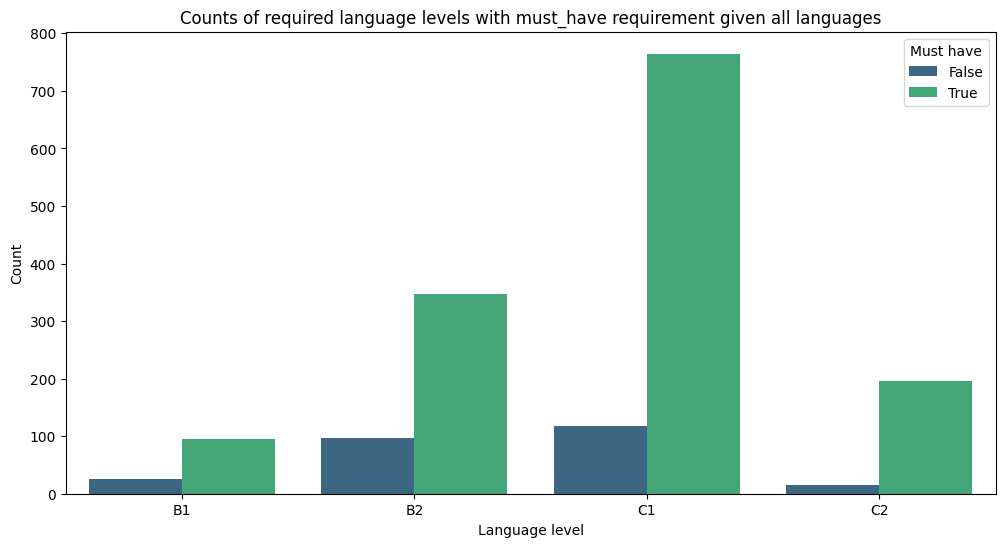

In [10]:
# creating a seaborn barplot per language levels and must_have requirement

plt.figure(figsize=(12, 6))
sns.barplot(data=features_job_languages_grouped, 
            x='rating', 
            y='cnt', 
            hue='must_have', 
            palette='viridis', 
            errorbar=None)
plt.title('Counts of required language levels with must_have requirement given all languages')
plt.xlabel('Language level')
plt.ylabel('Count')
plt.legend(title='Must have', loc='upper right')
plt.show()

<Figure size 1400x800 with 0 Axes>

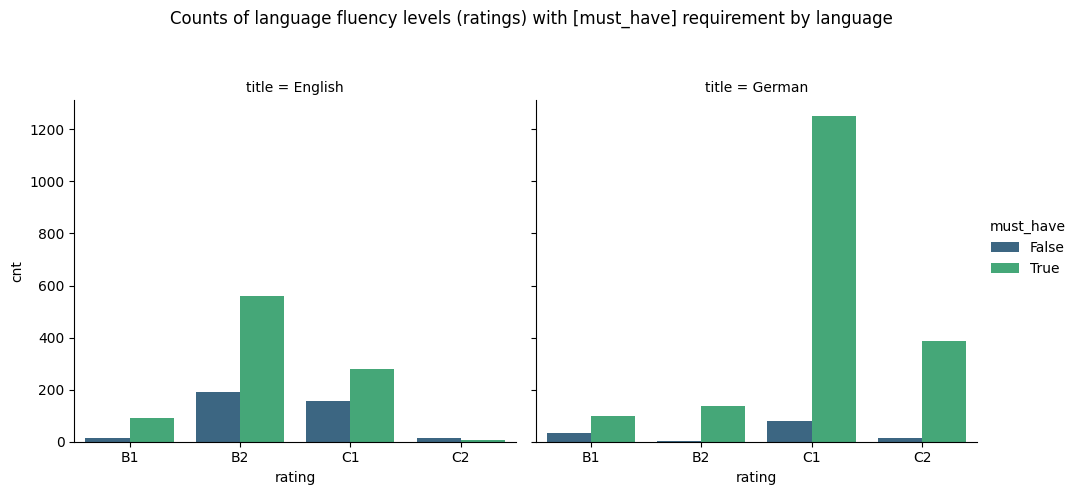

In [11]:
# creating a seaborn barplot for each language and language level

plt.figure(figsize=(14, 8))
sns.catplot(data=features_job_languages_grouped, 
            x='rating', 
            y='cnt', 
            hue='must_have', 
            col='title', 
            kind='bar', 
            palette='viridis', 
            errorbar=None,
            height=5, 
            aspect=1)
plt.subplots_adjust(top=0.8)
plt.suptitle('Counts of language fluency levels (ratings) with [must_have] requirement by language')
plt.show()

Job roles
---------

In [12]:
# we have created a little taxonomy for each job role in 'job' column
# it consists of 2 levels
# the goal is to create a frequency distribution per job category


job_roles_taxonomy_path = '/Users/milos/Downloads/instaffo_task/instaffo_match/data/job_roles_taxonomy.csv'
job_roles_taxonomy = pd.read_csv(job_roles_taxonomy_path)
job_roles_taxonomy = job_roles_taxonomy.sort_values(['category', 'subcategory', 'job_role'])

job_roles_taxonomy

,job_role,category,subcategory
9,data-analyst,IT,Data
10,data-engineer,IT,Data
11,data-scientist,IT,Data
28,security,IT,Security
0,backend-developer,IT,Software Development
3,c-c-developer,IT,Software Development
4,c-net-developer,IT,Software Development
5,cloud-engineer,IT,Software Development
12,devops-engineer,IT,Software Development
14,frontend-developer,IT,Software Development


In [13]:
# creating frequency table and merge it with taxonomy dataset

features_job_roles = pd.concat([pd.DataFrame(df['job'][x]['job_roles']) for x in range(0, df.shape[0])]).reset_index()
features_job_roles.columns = ['idx', 'job_role']
features_job_roles_freq = features_job_roles.job_role.value_counts().reset_index().rename(columns={'index' : 'cnt'})

features_job_roles_freq_with_taxonomies = pd.merge(job_roles_taxonomy, features_job_roles_freq, 'inner', 'job_role')

features_job_roles_freq_with_taxonomies

,job_role,category,subcategory,count
0,data-analyst,IT,Data,57
1,data-engineer,IT,Data,54
2,data-scientist,IT,Data,28
3,security,IT,Security,1
4,backend-developer,IT,Software Development,153
5,c-c-developer,IT,Software Development,42
6,c-net-developer,IT,Software Development,22
7,cloud-engineer,IT,Software Development,16
8,devops-engineer,IT,Software Development,38
9,frontend-developer,IT,Software Development,659


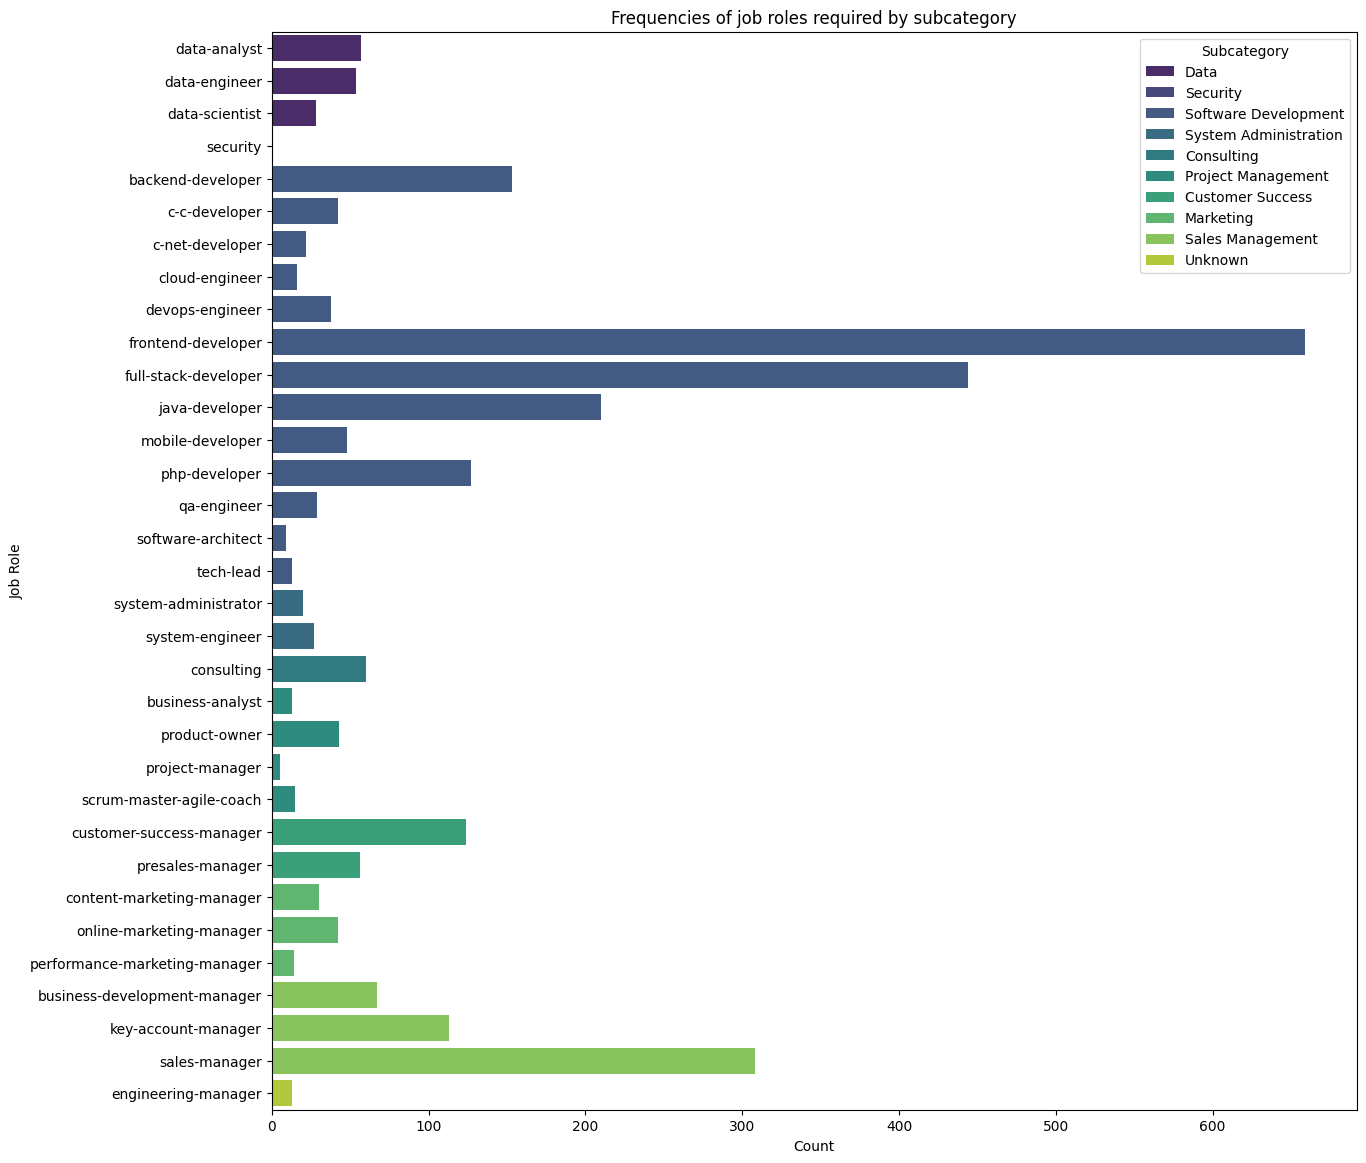

In [14]:
# create a barplot showing frequencies of job roles per subcategory

plt.figure(figsize=(14, 14))
sns.barplot(
    data=features_job_roles_freq_with_taxonomies, 
    x='count', 
    y='job_role', 
    hue='subcategory', 
    palette='viridis', 
    dodge=False
)
plt.title('Frequencies of job roles required by subcategory')
plt.xlabel('Count')
plt.ylabel('Job Role')
plt.legend(title='Subcategory', loc='upper right')
plt.show()

<Figure size 2400x1300 with 0 Axes>

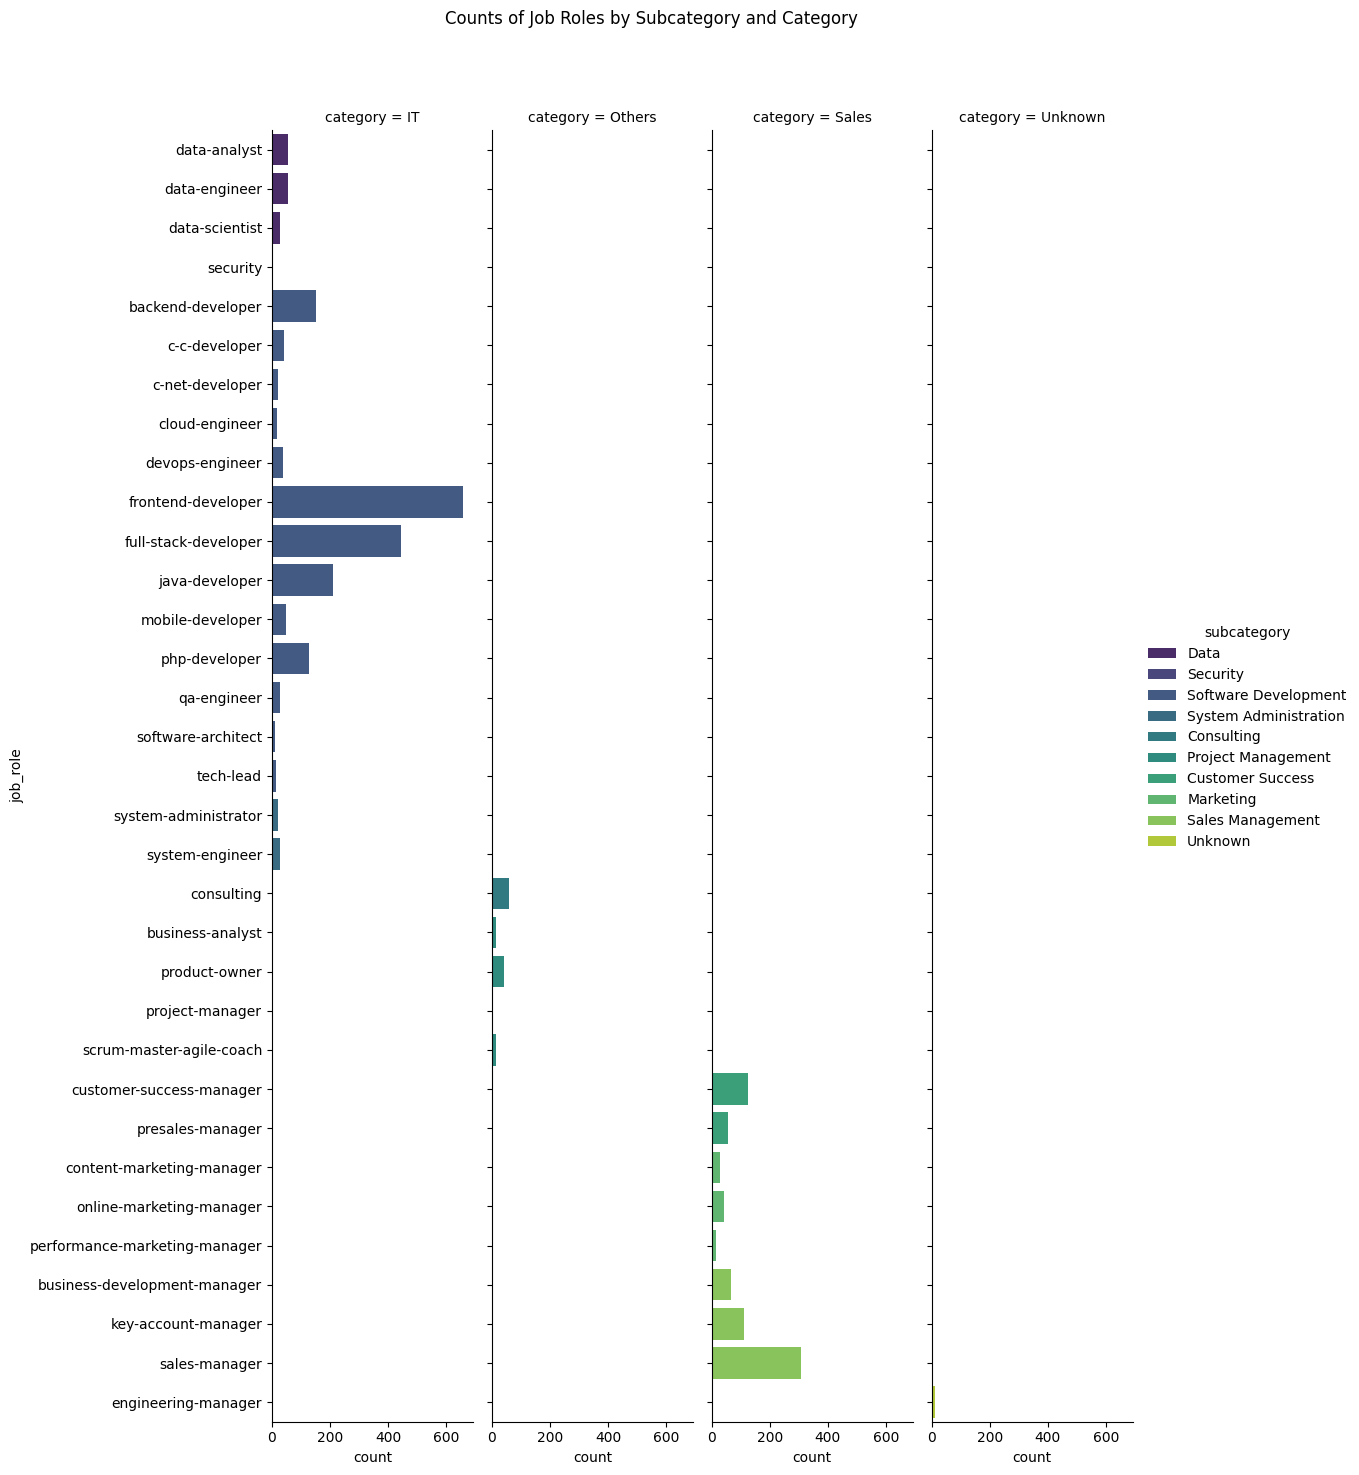

In [15]:
# create a seaborn barplot for each job category & subcategory

plt.figure(figsize=(24, 13))
sns.catplot(
    data=features_job_roles_freq_with_taxonomies,
    x='count', 
    y='job_role', 
    hue='subcategory', 
    col='category', 
    kind='bar', 
    palette='viridis', 
    height=15, 
    aspect=0.2
)
plt.subplots_adjust(top=0.9)
plt.suptitle('Counts of Job Roles by Subcategory and Category')
plt.show()

Seniorities
-----------

In [16]:
features_seniorities = pd.concat([pd.DataFrame(df['job'][x]['seniorities']) for x in range(0, df.shape[0])]).reset_index(drop=True)
features_seniorities.columns = ['seniority']
features_seniorities_freq = features_seniorities.seniority.value_counts().reset_index()
features_seniorities_freq

,seniority,count
0,midlevel,1763
1,junior,1283
2,senior,1104
3,none,335


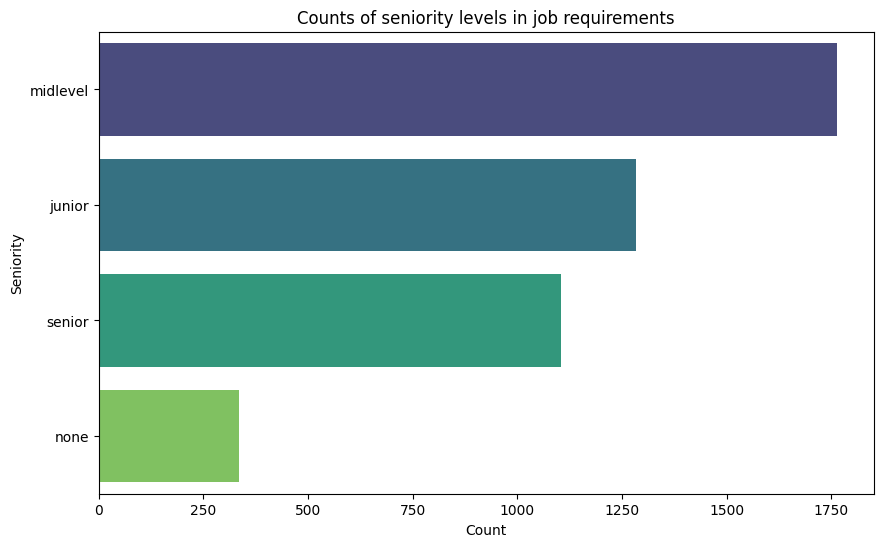

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='seniority', hue='seniority', data=features_seniorities_freq, palette='viridis', errorbar=None)
plt.title('Counts of seniority levels in job requirements')
plt.xlabel('Count')
plt.ylabel('Seniority')
plt.show()

Degrees
-------

In [18]:
features_degrees = pd.DataFrame([df['job'][x]['min_degree'] for x in range(0, df.shape[0])]).reset_index(drop=True)
features_degrees.columns = ['degree']
features_degrees_freq = features_degrees.degree.value_counts().reset_index()
features_degrees_freq

,degree,count
0,none,899
1,bachelor,467
2,master,245
3,apprenticeship,195
4,doctorate,194


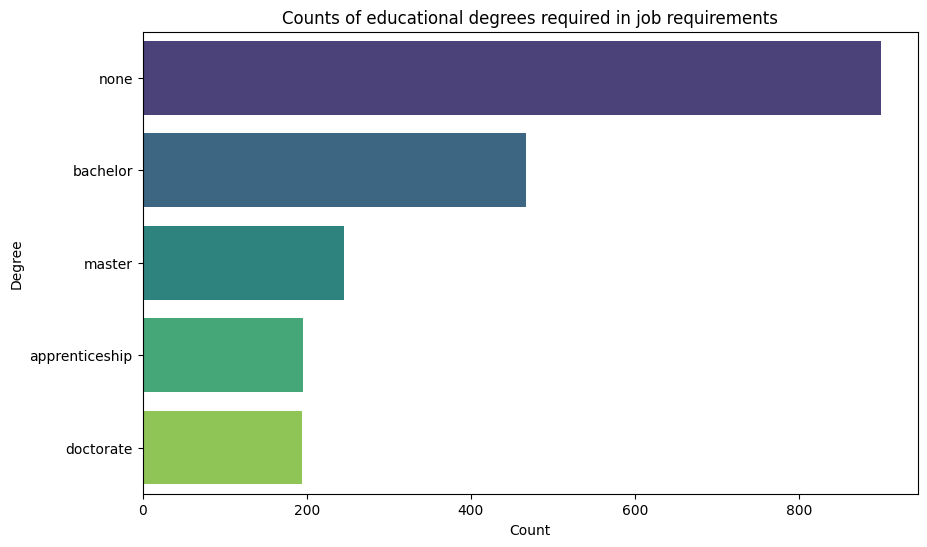

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='degree', hue='degree', data=features_degrees_freq, palette='viridis', errorbar=None)
plt.title('Counts of educational degrees required in job requirements')
plt.xlabel('Count')
plt.ylabel('Degree')
plt.show()

# FEATURE IMPORTANCE

In [183]:
def get_feature_importance(model, feature_names):
    """
    Get feature importance from the logistic regression model.

    Parameters
    ----------
    model : sklearn.pipeline.Pipeline
        The trained logistic regression model (possibly within a pipeline).
    feature_names : list of str
        List of feature names.

    Returns
    -------
    importance_df : pd.DataFrame
        DataFrame with features and their corresponding importance.
    """
    # Check if the model is a pipeline and extract the logistic regression model
    if hasattr(model, 'steps'):
        for name, step in model.steps:
            if hasattr(step, 'coef_'):
                model = step
                break
    
    if not hasattr(model, 'coef_'):
        raise ValueError("Model does not have coefficients. Ensure it's a logistic regression model.")

    importance = model.coef_[0]
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    importance_df['Abs_Importance'] = np.abs(importance_df['Importance'])
    importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)
    return importance_df


In [186]:
get_feature_importance(model, features)[['Feature', 'Importance']]

,Feature,Importance
1,degree_match,5.256405
0,seniority_match,5.018309
2,salary_match,4.869884
4,job_role_match,4.588040
3,language_match,2.018224


## 3) PREPROCESSING

Notes
------

1) There are multiple seniorities in 'job - seniorities' entity, 
which might lead to a certain confusion which seniority level is actually desired.
We have decided to go for the intuition: if there are different seniorities present, we'd argue that
minimal mapped seniority value is enough but will compare this logic against the label class in data analysis step.
In case there is "none" among other seniorities, we would speculate that no seniority is actually mandatory,
while other seniorities present are good to have.

3) Sometimes job language has a value "must_have" == False, meaning that this is a good to have, 
rather a compulsory requirement for a job.
We'd speculate that if we have a "must have" == False, we'd ignore this language as a criterion

4) Sometimes required job_roles contains multiple job roles, and sometimes talent roles can also contain multipls job roles.
We'll establish the rule by which there is a match between talent and job roles if any of required job roles is found in talent roles


In [185]:
# job data

df['job'][0]

{'languages': [{'title': 'German', 'rating': 'C1', 'must_have': True},
  {'title': 'English', 'rating': 'B2', 'must_have': True}],
 'job_roles': ['frontend-developer'],
 'seniorities': ['junior', 'midlevel'],
 'max_salary': 70000,
 'min_degree': 'none',
 'seniorities_mapped': [1, 2],
 'degree_mapped': 0}

In [ ]:
# talent data

df['talent'][0]

In order to get the dataset ready for data modeling, we need to map any categorical (textual) value given,
provided it makes sense to do the mapping.

3a) map categorical values to numerical ordered values in a dict:

- language levels (to numerical ordered) going from none to C2 in ascenging order from 0 to 32
- seniorities (to numerical ordered) going from none to senior in ascending order from 0 to 5
- degrees (to numerical ordered) going from none to doctorate in ascending order from 0 to 4

3b) implement mapping in a dataset as new columns


In [137]:
# mapping dictionaries
# we take non-linear approach - we put more weight on more advanced levels of features, needed for comparing and scoring

language_levels = {
    'none' : 0,
    'A1' : 1,
    'A2' : 2,
    'B1' : 4,
    'B2' : 8,
    'C1' : 16,
    'C2' : 32  
}

seniorities = {
    'none' : 0,
    'junior' : 1,
    'midlevel' : 3,
    'senior' : 5
}

degrees = {
    'none' : 0,
    'apprenticeship' : 1,
    'bachelor' : 2,
    'master' : 3,
    'doctorate' : 4  
}


In [138]:
# mapping function

def map_values(entry, language_levels, seniorities, degrees):
    # deep copy which avoids modifying the original values
    entry = copy.deepcopy(entry)
    
    # map language levels (a bit different function from the rest of mappimng functions with field being a dict)
    for language in entry['languages']:
        language['rating'] = language_levels.get(language['rating'], 0)
    
    # map talent seniority (single value for talent)
    if 'seniority' in entry:
        entry['seniority'] = seniorities.get(entry['seniority'], 0)
    
    # map talent educational degree (single value for talent)
    if 'degree' in entry:
        entry['degree'] = degrees.get(entry.get('degree', 'none'), 0)
    
    # map job seniorities (multiple values for job)
    if 'seniorities' in entry:
        entry['seniorities'] = [seniorities.get(s, 0) for s in entry['seniorities']]
    
    # map required min_degree (single value for job)
    if 'min_degree' in entry:
        entry['min_degree'] = degrees.get(entry.get('min_degree', 'none'), 0)
    
    return entry

# Create new columns 'talent_mapped' and 'job_mapped' based on mapping dictionaries provided above

df['talent_mapped'] = df['talent'].apply(lambda x: map_values(copy.deepcopy(x), language_levels, seniorities, degrees))

df['job_mapped'] = df['job'].apply(lambda x: map_values(copy.deepcopy(x), language_levels, seniorities, degrees))


In [139]:
# checking original vs mapped 

In [140]:
df['talent'][0]

{'languages': [{'rating': 'C2', 'title': 'German'},
  {'rating': 'C2', 'title': 'English'},
  {'rating': 'B2', 'title': 'French'},
  {'rating': 'A2', 'title': 'Turkish'}],
 'job_roles': ['frontend-developer',
  'backend-developer',
  'full-stack-developer',
  'java-developer',
  'mobile-developer'],
 'seniority': 'junior',
 'salary_expectation': 48000,
 'degree': 'bachelor',
 'seniority_mapped': 1,
 'degree_mapped': 2}

In [141]:
df['talent_mapped'][0]

{'languages': [{'rating': 32, 'title': 'German'},
  {'rating': 32, 'title': 'English'},
  {'rating': 8, 'title': 'French'},
  {'rating': 2, 'title': 'Turkish'}],
 'job_roles': ['frontend-developer',
  'backend-developer',
  'full-stack-developer',
  'java-developer',
  'mobile-developer'],
 'seniority': 1,
 'salary_expectation': 48000,
 'degree': 2,
 'seniority_mapped': 1,
 'degree_mapped': 2}

Note:
-----

Here we can see that values of language levels, seniority and degree are succesfully replaced with ordered numercial values in a new column 'talent_mapped'

## 4) FEATURE EXTRACTION

We are assuming that following features have the biggest importance in deciding whether a talent is a mtch or not:

- language
- seniority
- degree
- job roles
- salary

The idea is to create new 5 features as boolean values for each of features mentioned, respectively, based on roles we established above:
('1' for match or '0' for no match):

- language_match
- seniority_match
- degree_match
- job_roles_match
- salary_match

That would be base to creating independent variables or inputs in model, while label would be dependent variable.


4a) Scoring mechanism
---------------------

Further in notebook we will see that logistic regression binary classification model has a solid matching prediction.
However, it does not give us insight on how to rank candidates.

With mapping of categorical features to ordered numerical weights, and with addition of already numerical feature like salary, we would be able to create a scoring mechanism which would differentiate candidates by weighted features properties.

Scoring mechanism is a postprocessing step, which serves to rank candidates who match job criteria.

So we have two criteria:

1) primary: matching criteria (whether a candidate is a match or not given parameters defined)
2) secondary: scoring criteria (ranking matched candidates by weighted performance score in descending order)

We will elaborate this approach in lines to follow.


# 4b) Adding criteria features

a) Seniority:

1) primary criteria: if multiple seniorities are given, take minimum required seniority (plugs into the model as a feature)
2) secondary criteria: weight seniority by comparing seniority levels


In [142]:
df['required_min_seniority'] =[min(df['job_mapped'][x]['seniorities']) for x in range(0, df.shape[0])]
df['talent_seniority'] =[df['talent_mapped'][x]['seniority'] for x in range(0, df.shape[0])]
df['seniority_match'] = np.where(df.talent_seniority >= df.required_min_seniority, 1 ,0)
df['seniority_match_weight'] = df.talent_seniority-df.required_min_seniority


b) Educational degree:

1) primary criteria: if talent degree has same or better educational degree from the one required in job, we have a match (plugs into the model as a feature)
2) secondary criteria: weight degree by comparing job required degrees with talent degree


In [143]:
df['required_min_degree'] = [df['job_mapped'][x]['min_degree'] for x in range(0, df.shape[0])]
df['talent_degree'] = [df['talent_mapped'][x]['degree'] for x in range(0, df.shape[0])]
df['degree_match'] = np.where(df.talent_degree >= df.required_min_degree, 1 ,0)
df['degree_match_weight'] = df.talent_degree-df.required_min_degree

c) Language:

1. primary criteria: exists only if a column "must_have" for particular language has a value True
2. secondary criteria: required language fluency levels are weighted against language levels of a talent


In [145]:
# create language levels matching criterion
# the language criterion exists only if a column "must_have" for particular language has a value True
# in that case, required language fluency levels are matched against language levels of a talent

def check_language_match(talent_languages, job_languages):
    try:
        # Creating a dictionary for talent language levels with weights
        talent_language_dict = {lang['title']: language_levels[lang['rating']] for lang in talent_languages}
        
        total_weight = 0  # initiated total weight of all 'must_have' job languages
        match_count = 0  # initiated total weight of matched 'must_have' job languages
        all_must_have_met = True  # flag to check if all must_have requirements are met

        for job_language in job_languages:
            # Only consider 'must_have' job languages
            if job_language.get('must_have', False):
                job_title = job_language['title']
                job_rating = language_levels[job_language['rating']]
                total_weight += job_rating
        
                # Check if the talent has the required level for the 'must_have' job language
                talent_rating = talent_language_dict.get(job_title, 0)
                if talent_rating >= job_rating:
                    match_count += job_rating  # Add the weight of the 'must_have' job language to total weight
                else:
                    all_must_have_met = False  # Mark that not all must_have requirements are met

        threshold = 0.5 # Define the threshold for matching (50% of total weight)
        is_match = all_must_have_met and (match_count >= threshold * total_weight)  # Determine if the match count meets the threshold
        
        return int(is_match), total_weight # Return the match result (1 for match, 0 for no match) and total weight

    except KeyError as e:
        logger.error("KeyError occurred", exc_info=True)
        return 0, 0
    except TypeError as e:
        logger.error("TypeError occurred", exc_info=True)
        return 0, 0
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        logger.error("Exception occurred in %s at line %d", fname, exc_tb.tb_lineno, exc_info=True)
        print(exc_type, fname, exc_tb.tb_lineno)
        return 0, 0


df['language_match'], df['language_match_weight'] = zip(*df.apply(lambda row: check_language_match(row['talent']['languages'], 
                                                                                         row['job']['languages']), axis=1))

df['language_match_weight'] = df['language_match_weight']/100


d) Job roles:

1. primary criteria: both job roles are present in talent and in job description, if talent has at least one job role which matches with all required roles, it's a match
2. secondary criteria: number of job roles in common both for talent and job description. Intuition: the more talent jobs and requiret list of jobs are in common, the better prospects for talent to be employed 


In [30]:
def check_job_role_match(talent_job_roles, job_job_roles):
    try:
        # return any(role in job_job_roles for role in talent_job_roles)
        if any(role in job_job_roles for role in talent_job_roles):
            return 1
        return 0
        
    except TypeError as e:
        logger.error("TypeError occurred", exc_info=True)
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        logger.error("Exception occurred in %s at line %d", fname, exc_tb.tb_lineno, exc_info=True)
        print(exc_type, fname, exc_tb.tb_lineno)

# check role(s) match

df['job_role_match'] = df.apply(lambda row: check_job_role_match(row['talent_mapped']['job_roles'], 
                                                                 row['job_mapped']['job_roles']), axis=1)


In [31]:
# the secondary criteria calculates number of jor_roles matched

def count_matching_roles(talent_job_roles, job_job_roles):
    try:
        # Count the number of matching roles
        return sum(role in job_job_roles for role in talent_job_roles)
        
    except TypeError as e:
        logger.error("TypeError occurred", exc_info=True)
        return 0
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        logger.error("Exception occurred in %s at line %d", fname, exc_tb.tb_lineno, exc_info=True)
        print(exc_type, fname, exc_tb.tb_lineno)
        return 0

df['job_role_match_weight'] = df.apply(lambda row: count_matching_roles(row['talent']['job_roles'], row['job']['job_roles']), axis=1)


e) Salary:

1. primary criteria: if salary expectation of a talent is larger than job allowed max.salary, it's a match
2) secondary criteria: calculate difference between max_salary allowed and expected salary by talent


In [32]:

df['salary_talent'] = [df['talent'][x]['salary_expectation'] for x in range(0, df.shape[0])]
df['salary_job'] = [df['job'][x]['max_salary'] for x in range(0, df.shape[0])]
df['salary_match'] = np.where(df.salary_job >= df.salary_talent, 1 ,0)
df['salary_match_weight'] = (df.salary_job - df.salary_talent)/10000


In [33]:
# converting label to numerical value

df['label'] = np.where(df.label==False, 0 ,1)


In [34]:
# adding score as cumulative weight

df['score'] = \
    df.language_match_weight + \
    df.job_role_match_weight + \
    df.degree_match_weight + \
    df.seniority_match_weight + \
    df.salary_match_weight


In [35]:
# displaying the base of model inputs

df[['job', 'talent', 'language_match', 'job_role_match', 'degree_match', 'seniority_match', 'salary_match', 'label', 'score']].head(10)


,job,talent,language_match,job_role_match,degree_match,seniority_match,salary_match,label,score
0,"{'languages': [{'title': 'German', 'rating': '...","{'languages': [{'rating': 'C2', 'title': 'Germ...",1,1,1,1,1,1,5.44
1,"{'languages': [{'title': 'German', 'rating': '...","{'languages': [{'rating': 'C2', 'title': 'Germ...",1,1,1,1,1,1,6.84
2,"{'languages': [{'title': 'German', 'rating': '...","{'languages': [{'rating': 'C2', 'title': 'Engl...",1,1,1,1,1,1,5.66
3,"{'languages': [{'title': 'German', 'rating': '...","{'languages': [{'rating': 'C2', 'title': 'Germ...",1,1,1,1,1,1,4.64
4,"{'languages': [{'title': 'German', 'rating': '...","{'languages': [{'rating': 'C2', 'title': 'Germ...",1,1,1,1,1,1,3.66
5,"{'languages': [{'title': 'German', 'rating': '...","{'languages': [{'rating': 'C2', 'title': 'Germ...",1,1,1,1,1,1,6.82
6,"{'languages': [{'title': 'German', 'rating': '...","{'languages': [{'rating': 'C2', 'title': 'Germ...",1,1,1,1,1,1,5.82
7,"{'languages': [{'title': 'German', 'rating': '...","{'languages': [{'rating': 'C2', 'title': 'Engl...",1,1,1,1,1,1,4.92
8,"{'languages': [{'title': 'English', 'rating': ...","{'languages': [{'rating': 'C2', 'title': 'Germ...",1,1,1,1,0,1,4.66
9,"{'languages': [{'title': 'German', 'rating': '...","{'languages': [{'rating': 'C2', 'title': 'Engl...",1,1,1,1,1,1,4.74


##  5) DATA ANALYSIS

## 5a) Mismatch analysis

In [36]:
# we want to check whether established rules for primary criteria are meaningful.

# thus we create two new datasets:

# 1) 

# dataset with label set as False, which implements a rule that
# if any given criterion above is not match,
# then talent don't match

negatives = df[
    (df.label==0) & 
    ((df.seniority_match==0) |
    (df.degree_match==0) |
    (df.language_match==0) |
    (df.salary_match==0) |
    (df.job_role_match==0))
].idx.tolist()

# 2)

# dataset with label set as True, which implements a rule that
# if all given criterions do match,
# then talent is a match

positives = df[
    (df.label==1) & 
    ((df.seniority_match == 1) &
    (df.degree_match == 1) &
    (df.language_match==1) &
    (df.salary_match==1) &
    (df.job_role_match==1))
].idx.tolist()



In [37]:
# with these two datasets we want to check whether our established rules have a ground

# we collect both datasets
idx_recognizes = negatives + positives

# we create third dataset showing cases where our rules are not ok
mismatches = df[~df.idx.isin(idx_recognizes)]\
[['idx', 'seniority_match', 'degree_match', 'language_match', 'job_role_match', 'salary_match', 'label']]


In [38]:
print('Number of records confirming hypotheses that our rules are adequate:', len(idx_recognizes), '(', 
      (len(idx_recognizes)/df.shape[0])*100,'%)')

print('Number of records which do not follow pattern of rules established:', len(mismatches.idx.tolist()),  '(', 
      (len(mismatches.idx.tolist())/df.shape[0])*100,'%)')

Number of records confirming hypotheses that our rules are adequate: 1804 ( 90.2 %)
Number of records which do not follow pattern of rules established: 196 ( 9.8 %)


In [39]:
df['job'][1126]

{'languages': [{'title': 'German', 'rating': 'C1', 'must_have': True},
  {'title': 'English', 'rating': 'B2', 'must_have': True}],
 'job_roles': ['frontend-developer'],
 'seniorities': ['junior', 'midlevel'],
 'max_salary': 70000,
 'min_degree': 'none'}

In [40]:
df['talent'][1126]

{'languages': [{'rating': 'C2', 'title': 'German'},
  {'rating': 'A2', 'title': 'English'}],
 'job_roles': ['frontend-developer',
  'backend-developer',
  'c-net-developer',
  'java-developer',
  'c-c-developer'],
 'seniority': 'junior',
 'salary_expectation': 25000,
 'degree': 'bachelor'}

We now want to create a little outlier analysis, in order to find the cause of mismatched records not aligned with established rules.


In [41]:
# we take 196 misligned records.
# first we take all misaligned records with label 0:
# some of profiles, despite having all qualifications, have not passed initial matching for some reason,
# unknown to us at this moment

mismatches[mismatches.label==0]


,idx,seniority_match,degree_match,language_match,job_role_match,salary_match,label
1038,1038,1,1,1,1,1,0
1054,1054,1,1,1,1,1,0
1183,1183,1,1,1,1,1,0
1722,1722,1,1,1,1,1,0
1803,1803,1,1,1,1,1,0
1849,1849,1,1,1,1,1,0
1903,1903,1,1,1,1,1,0
1925,1925,1,1,1,1,1,0
1973,1973,1,1,1,1,1,0


In [43]:
# all talents with all qualifications except the salary, are taken into account
# then we take all misaligned records with label 1:

mismatches[(mismatches.label==1) & (mismatches.salary_match==1)]


,idx,seniority_match,degree_match,language_match,job_role_match,salary_match,label


In [44]:
# interestingly, there is one exception to the rule:
# if all other criterion match except for the salary, there are 187 out of 2000 records
# which have positive label 

mismatches[mismatches.label==1]

,idx,seniority_match,degree_match,language_match,job_role_match,salary_match,label
8,8,1,1,1,1,0,1
12,12,1,1,1,1,0,1
15,15,1,1,1,1,0,1
22,22,1,1,1,1,0,1
24,24,1,1,1,1,0,1
...,...,...,...,...,...,...,...
979,979,1,1,1,1,0,1
988,988,1,1,1,1,0,1
991,991,1,1,1,1,0,1
995,995,1,1,1,1,0,1


also, if we cross check other features for misaligned records which are accepted without salary match, we can see
that there are no other traceable patterns in reasoning why these talents are accepted, except for some other reasons

# Visualizing distribution of misaligned records

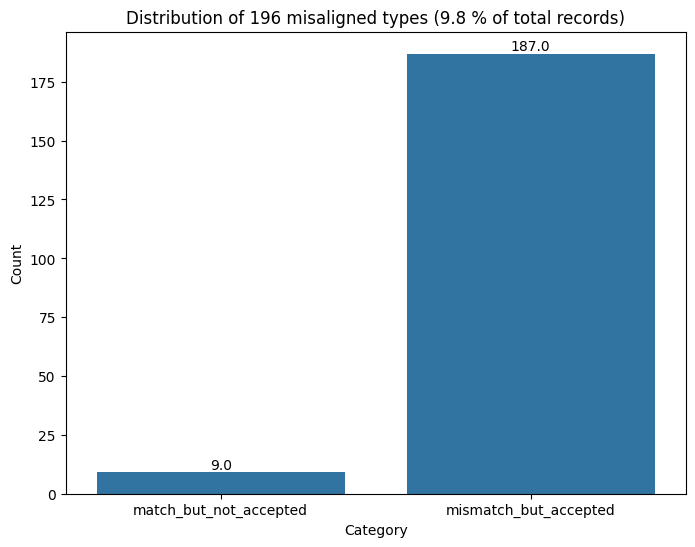

In [46]:
# misaligned records which were accepted as match nonetheless
mismatch_but_accepted = mismatches[mismatches.label==1].idx.tolist()

# misaligned records which were rejected despite being fully matched
match_but_not_accepted = mismatches[mismatches.label==0].idx.tolist()

df_mismatch = pd.DataFrame(
    {
        'match_but_not_accepted' : [len(match_but_not_accepted)],
        'mismatch_but_accepted' : [len(mismatch_but_accepted)]                                     
                                       }
)

# melting the dataframe to a long format
df_melted = df_mismatch.melt(var_name='Category', value_name='Count')

total_mismatch = df_mismatch.match_but_not_accepted.tolist()[0] + df_mismatch.mismatch_but_accepted.tolist()[0]

mismatch_perc = total_mismatch/df.shape[0]*100

# plotting
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Category', y='Count', data=df_melted)

# Annotate the bars with the counts
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.title(f'Distribution of {total_mismatch} misaligned types ({mismatch_perc:.1f} % of total records)')
plt.ylabel('Count')
plt.xlabel('Category')
plt.show()

# Analisys of possible multicolinearity between predictors

We will create a correlation matrix to check whether there is a strong corellation between pairs of features. Should there be any strong multicolineartity, that would affect the accuracy of the model and its ability to capture patterns for prediction

In [ ]:
features = ['seniority_match', 'degree_match', 'language_match', 'job_role_match', 'salary_match']

correlation_matrix = df[features].corr()

correlation_matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Boolean Predictors')
plt.show()

Interpretation of correlation matrix
------------------------------------

None of the correlations are very high (close to 1 or -1), suggesting that while there are relationships between the predictors, they are moderate. Absence of multicolinearity implies that logistic regression model won't be strongly affected by this result.

## 6) DATA EXPLORATION

We want to visualize all job titles on 2-dimensional graph using t-sne library,
which takes input (previously converted to numerical vectors) using TF-IDF concept,
reduces it to 2-dimensional output,
and plot the results on the graphicon

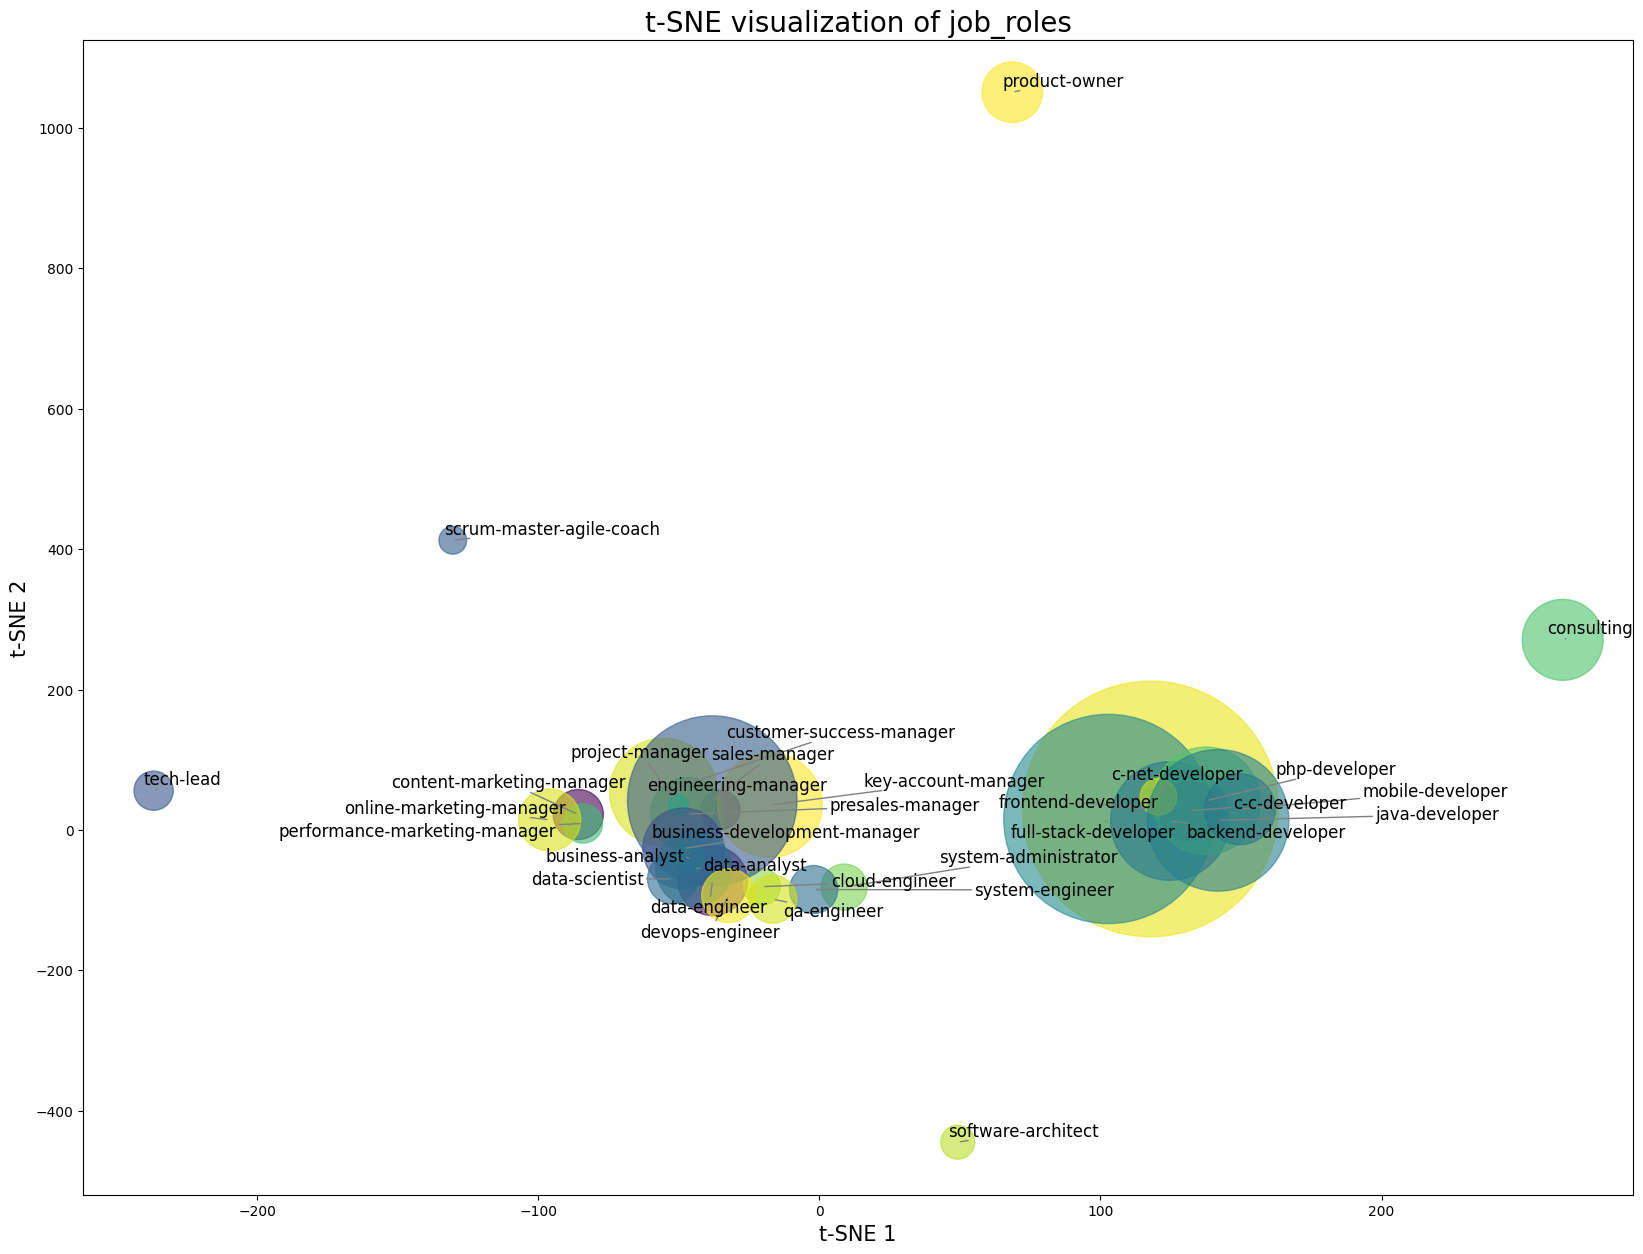

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from adjustText import adjust_text

def plot_tsne(tenant, feature, label):
    try:
        tenant_set = set()
        
        for index, row in df[df.label == label].iterrows():
            features = row[tenant][feature]
            for item in features:
                tenant_set.add(item)
        
        # converting the set to a list for processing
        features_list = list(tenant_set)
        
        # creating a dataFrame from the list of features
        features_df = pd.DataFrame(features_list, columns=[feature])
        
        # calculating the frequency of each feature
        frequency = df[df.label == label][tenant].apply(lambda x: pd.Series(x[feature])).stack().value_counts()
        frequency_df = frequency.reset_index()
        frequency_df.columns = [feature, 'frequency']
        
        # merging frequencies with features dataFrame
        features_df = features_df.merge(frequency_df, on=feature, how='left')
        
        # using TfidfVectorizer to convert features to TF-IDF features
        vectorizer = TfidfVectorizer()
        feature2vec = vectorizer.fit_transform(features_df[feature])
        
        # using t-SNE to reduce dimensionality (we can play with perplexity values to search for best result)
        tsne = TSNE(n_components=2, random_state=42, perplexity=5, learning_rate=100)
        X_tsne = tsne.fit_transform(feature2vec.toarray())
        
        # creating a scatter plot
        plt.figure(figsize=(20, 15))  # Increased figure size for better clarity
        
        # generating random colors
        colors = np.random.rand(len(features_df))
    
        # plotting scatterplot
        scatter = plt.scatter(
            X_tsne[:, 0], 
            X_tsne[:, 1], 
            s=features_df['frequency'] * 100, 
            c=colors, 
            alpha=0.6, 
            cmap='viridis'
        )
        
        # annotating points with features
        texts = []
        for i, txt in enumerate(features_df[feature]):
            texts.append(plt.text(X_tsne[i, 0], X_tsne[i, 1], txt, fontsize=12, ha='center'))
        
        # adjusting text positions to avoid overlap and add pointer lines where applicable
        adjust_text(texts, 
                    only_move={'points':'y', 'text':'xy'}, 
                    arrowprops=dict(arrowstyle='-', color='gray', lw=1))
        
        plt.title(f't-SNE visualization of {feature}', fontsize=20)
        plt.xlabel('t-SNE 1', fontsize=15)
        plt.ylabel('t-SNE 2', fontsize=15)
        plt.show()

    except Exception as e:
            
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(ix, exc_type, fname, exc_tb.tb_lineno)

# run t-sne over job_roles

plot_tsne('job', 'job_roles', 1)

Analysis note
--------
Since job_role is used solely as an input in t-sne, this model only captures a semantical information
This is why engineers, managers, developers and data people are clustered seprately.


## 7) ML MODEL - LOGISTIC REGRESSION

In [51]:
# since we've seen intuitively, during the data analysis part, that matching truly depends on features we selected,
# we will plug in the matching values into the logistic regression model as predictors, or independent variables.

# defining predictors (features from the dataset) and class (label) as dependent variable

features = ['seniority_match', 'degree_match', 'salary_match', 'language_match', 'job_role_match']

X = df[features]
y = df['label'].tolist()


We are here dealing with binary classification priblem (predicting whether a talent is a match to job requirement or not).
We'd pick logistic regression to start with, since we have 5 features as predictors.
No need for PCA or SVD for now.

In [52]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Defining pipeline for logistic regression
model = make_pipeline(
    DictVectorizer(sparse=False),
    LogisticRegression()
)

# Train-test split on 80% - 20% rule
X_train, X_test, y_train, y_test = train_test_split(X.to_dict(orient='records'), y, test_size=0.2, random_state=42)

# Fiting the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Model evaluation
accuracy = model.score(X_test, y_test)

print(f"Accuracy: {accuracy}")

# probabilities (scores)

y_pred_prob = model.predict_proba(X_test)[:, 1]

# confidence scores as probabilities of selected talent being a good fit for the job

scores = model.predict_proba(X_test)[:, 1]


Accuracy: 0.9775


In [53]:
# example of input features (predictors) plugged into the model

X_test[375]

{'seniority_match': 1,
 'degree_match': 0,
 'salary_match': 1,
 'language_match': 1,
 'job_role_match': 1}

In [54]:
# binary prediction (can be only 0 or 1)

y_pred[375]

0

In [55]:
# score (probability, confidence) that we can safely predict match
# the closer to 1, the more likely it will be match

scores[375]

0.14301363063141426

## 8) EVALUATION - CONFUSION MATRIX

In [56]:
# binary classification problem is evaluated by a confusion matrix on testing dataset consisting of 400 records (20% of total records)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


Definitions:
------------
- true positives = predicted = true, in reality = true
- false positives = predicted = true, in reality = false
- true negatives = predicted = false, in reality = false
- false negatives = predicted = false, in reality = true

Confusion Matrix: A table used to describe the performance of the classification model. 
It shows the true positives, true negatives, false positives, and false negatives.


In [57]:
# true negatives (192) being correctly classified as not matched
# true positives (199) being correctly classified as matched

df_confusion_matrix = pd.DataFrame(conf_matrix)

df_confusion_matrix

,0,1
0,192,9
1,0,199


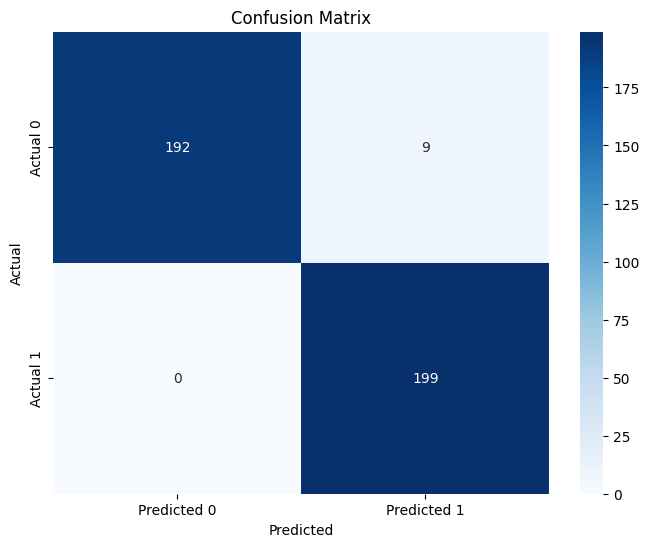

In [58]:
# Plot confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion_matrix,
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Metrics:
--------

- accuracy: ratio of correctly predicted vs total number of records: (192 + 199) / 400 = 0.98
- precision: ratio true positives vs all predicted as positive: 199 / (199 + 9) = 0.96)
- recall: ratio true positives (TP) vs total correctly predicted TP/(TP + FN) (model's ability to capture all accurate instances): 199/(199+0) = 1.00
- F1 Score: The weighted average of precision and recall (balance between precision and recall)
- F1 = 2 * (Precision * Recall) / (Precision + Recall) = 2 * (0.96 * 1)/(0.96 + 1) = (2 * 0.96) / 1.96 = 1.92 / 1.96 = 0.98
- Classification Report: Provides a detailed report of precision, recall, f1 score, and support for each class.


In [59]:
print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       201
           1       0.96      1.00      0.98       199

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



Evaluation results breakdown
----------------------------

-----------
precision
-----------

precision for class 0 is 1.00, meaning all instances predicted as class 0 are actually class 0
for class 1, the precision is 0.96, indicating that 96% of the instances predicted as class 1 are correct.

--------
recall
--------

recall for class 0 is 0.96, meaning the model correctly identified 96% of the actual class 0 instances
for class 1, the recall is 1, meaning the model correctly identified all actual class 1 instances.

----
f1
----

f1 as harmonic mean of precision and recall, is 0.98 for both classes, indicating a balanced performance.

----------
accuracy
----------

the overall accuracy of the model is 0.9775, indicating that 97.8% of the total predictions were correct.

---------
support
---------

showsing the number of actual instances for each class. the classes are in balance, 
with almost equal distribution of records for class 0 and class 1.

---------------------------
macro vs weighted average
---------------------------

macro average gives the average performance across classes without considering class imbalance
weighted average takes the class distribution into account. 
both metrics are similar, indicating the model performs consistently across both classes.


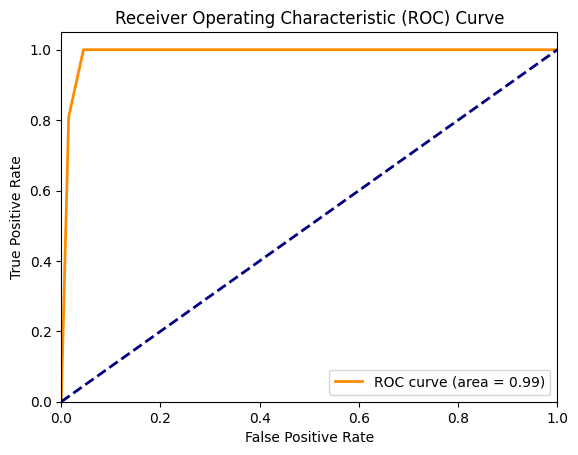

In [60]:
# ROC curve

# ROC (receiver operating characteristic) is a graph showing a ratio true positives vs false positives
# given different thresholds

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


ROC curve
----------

roc_curve function computes the false positive rate (FPR) and true positive rate (TPR) for different threshold values.
auc function calculates the area under the ROC curve.

The diagonal line represents the performance of a random classifier.
--------------------------------------------------------------------

roc curve plot visualizes the model’s performance.
auc score: the area under the ROC curve, indicating the overall performance of the model, which is very good



## WRITING A MODEL TO DISK 

In [61]:
# Save the pipeline to a file

import joblib

model_filename = '/Users/milos/downloads/logistic_regression_model_final.pkl'
joblib.dump(model, model_filename)
print(f"Pipeline saved to {model_filename}")


Pipeline saved to /Users/milos/downloads/logistic_regression_model_final.pkl


# TEST THE MODEL - BREAKDOWN OF UTILITY FUNCTIONS

## 1) Create a function to transform and map input inside dictionaries inputs

In [62]:
def transform_input(input_dict, dict_type):

    try:
    
        if dict_type == 'job':
        
            # creating empty dict
            transformed = {}
            
            # transform languages

            transformed['languages'] = [
                {
                    'title': lang['title'],
                    'rating': language_levels.get(lang['rating'], 0),
                    'must_have': lang['must_have']
                } 
                for lang in input_dict['languages'] if lang['must_have']
            ]
                                
            # Transform job_roles (keep as it is)
            transformed['job_roles'] = input_dict['job_roles']
            
            # Transform seniorities
            transformed['seniorities'] = [
                seniorities.get(sen, 0) for sen in input_dict['seniorities']
            ]
            
            # Transform max_salary (keep as it is)
            transformed['max_salary'] = input_dict['max_salary']
            
            # Transform min_degree
            transformed['min_degree'] = degrees.get(input_dict['min_degree'], 0)
            
            return transformed
    
        if dict_type == 'talent':
    
            # creating empty dict
            transformed = {}
            
            # transform languages
            transformed['languages'] = [
                {
                    'title': lang['title'],
                    'rating': language_levels.get(lang['rating'], 0)
                } 
                for lang in input_dict['languages']
            ]
            
            # Transform job_roles (keep as it is)
            transformed['job_roles'] = input_dict['job_roles']
            
            # Transform seniorities
            transformed['seniority'] = seniorities.get(input_dict['seniority'], 0)
            
            # Transform max_salary (keep as it is)
            transformed['salary_expectation'] = input_dict['salary_expectation']
            
            # Transform min_degree
            transformed['degree'] = degrees.get(input_dict['degree'], 0)
            
            return transformed

        else:

            print('wrong input')

    except Exception as e:

        raise('error:', e)
        
    

## 2. Select random talent and job requirement in a form of a dictionaries, as per task requirement

In [63]:

idx = 255

j_dict = df['job'][idx]
t_dict = df['talent'][idx]

In [64]:
j_dict

{'languages': [{'title': 'German', 'rating': 'C1', 'must_have': True},
  {'title': 'English', 'rating': 'B2', 'must_have': True}],
 'job_roles': ['frontend-developer'],
 'seniorities': ['junior', 'midlevel'],
 'max_salary': 70000,
 'min_degree': 'none'}

In [65]:
t_dict

{'languages': [{'rating': 'C2', 'title': 'German'},
  {'rating': 'C2', 'title': 'English'}],
 'job_roles': ['frontend-developer', 'full-stack-developer'],
 'seniority': 'midlevel',
 'salary_expectation': 75000,
 'degree': 'none'}

## 3. Transform (map) input dicts

In [66]:
t_job = transform_input(j_dict, 'job')
t_talent = transform_input(t_dict, 'talent')

In [67]:
t_job

{'languages': [{'title': 'German', 'rating': 16, 'must_have': True},
  {'title': 'English', 'rating': 8, 'must_have': True}],
 'job_roles': ['frontend-developer'],
 'seniorities': [1, 3],
 'max_salary': 70000,
 'min_degree': 0}

In [68]:
t_talent

{'languages': [{'title': 'German', 'rating': 32},
  {'title': 'English', 'rating': 32}],
 'job_roles': ['frontend-developer', 'full-stack-developer'],
 'seniority': 3,
 'salary_expectation': 75000,
 'degree': 0}

## 4. Create a function which checks the structure of input dictionaries

(making sure it fits task requirements)

In [69]:

def check_dict_structure(dict, dict_type):

    if dict_type == 'job':
    
        required_job_keys = {'languages', 'job_roles', 'seniorities', 'max_salary', 'min_degree'}
        if not all(key in dict for key in required_job_keys):
            raise ValueError("job_dict is missing required keys")
        
        if not isinstance(dict['languages'], list):
            raise TypeError("job_dict['languages'] should be a list")
        
        for lang in dict['languages']:
            if not all(key in lang for key in ['title', 'rating', 'must_have']):
                raise ValueError("Each language in job_dict must have 'title', 'rating', and 'must_have'")
    else:
        return('ok')

    
    if dict_type == 'talent':

        required_talent_keys = {'languages', 'job_roles', 'seniority', 'salary_expectation', 'degree'}
        if not all(key in dict for key in required_talent_keys):
            raise ValueError("talent_dict is missing required keys")
        
        if not isinstance(dict['languages'], list):
            raise TypeError("talent_dict['languages'] should be a list")
        
        for lang in dict['languages']:
            if not all(key in lang for key in ['title', 'rating']):
                raise ValueError("Each language in talent_dict must have 'title' and 'rating'")
    else:
        return('ok')
     

## 5. Function to match languages from dict

In [146]:

def match_language_from_dict(job_dict, talent_dict):

    if(check_dict_structure(job_dict, 'job') == 'ok' and check_dict_structure(talent_dict, 'talent') == 'ok'):
        pass
    else:
        raise('error in dict structure')

    transformed_job = transform_input(job_dict, 'job')
    transformed_talent = transform_input(talent_dict, 'talent')

    job_languages = transformed_job['languages']
    talent_languages = {lang['title']: lang['rating'] for lang in transformed_talent['languages']}

    for job_lang in job_languages:
        job_title = job_lang['title']
        job_rating = job_lang['rating']
        
        if job_title not in talent_languages or talent_languages[job_title] < job_rating:
            return 0
        
    return 1
    

In [71]:
print('Is language requirements met? (0 for no / 1 for yes):', match_language_from_dict(j_dict, t_dict))

Is language requirements met? (0 for no / 1 for yes): 1


## 6. Function to match seniority from dict

In [72]:

def match_seniority_from_dict(job_dict, talent_dict):

    if(check_dict_structure(job_dict, 'job') == 'ok' and check_dict_structure(talent_dict, 'talent') == 'ok'):
        pass
    else:
        raise('error in dict structure')

    transformed_job = transform_input(job_dict, 'job')
    transformed_talent = transform_input(talent_dict, 'talent')

    min_job_seniority = min(transformed_job['seniorities'])
    talent_seniority = transformed_talent['seniority']

    if talent_seniority >= min_job_seniority:
        return 1
    
    return 0
    

In [73]:
print('Is seniority requirements met? (0 for no / 1 for yes):', match_seniority_from_dict(j_dict, t_dict))

Is seniority requirements met? (0 for no / 1 for yes): 1


## 7. Function to match degree from dict inputs

In [74]:
def match_degree_from_dict(job_dict, talent_dict):

    if(check_dict_structure(job_dict, 'job') == 'ok' and check_dict_structure(talent_dict, 'talent') == 'ok'):
        pass
    else:
        raise('error in dict structure')

    transformed_job = transform_input(job_dict, 'job')
    transformed_talent = transform_input(talent_dict, 'talent')

    min_job_degree = transformed_job['min_degree']
    talent_degree = transformed_talent['degree']

    if talent_degree >= min_job_degree:
        return 1
    
    return 0
    

In [75]:
print('Is educational degree requirements met? (0 for no / 1 for yes):', match_degree_from_dict(j_dict, t_dict))

Is educational degree requirements met? (0 for no / 1 for yes): 1


## 8. Function to match salary from dict inputs

In [76]:
def match_salary_from_dict(job_dict, talent_dict):

    if(check_dict_structure(job_dict, 'job') == 'ok' and check_dict_structure(talent_dict, 'talent') == 'ok'):
        pass
    else:
        raise('error in dict structure')

    transformed_job = transform_input(job_dict, 'job')
    transformed_talent = transform_input(talent_dict, 'talent')

    job_max_salary = transformed_job['max_salary']
    talent_expected_salary = transformed_talent['salary_expectation']

    if talent_expected_salary <= job_max_salary:
        return 1
    
    return 0

In [77]:
print('Is salary requirements met? (0 for no / 1 for yes):', match_salary_from_dict(j_dict, t_dict))

Is salary requirements met? (0 for no / 1 for yes): 0


## 9. Function to match job roles from dict inputs

In [78]:
def match_job_roles_from_dict(job_dict, talent_dict):

    if(check_dict_structure(job_dict, 'job') == 'ok' and check_dict_structure(talent_dict, 'talent') == 'ok'):
        pass
    else:
        raise('error in dict structure')

    transformed_job = transform_input(job_dict, 'job')
    transformed_talent = transform_input(talent_dict, 'talent')

    job_roles = transformed_job['job_roles']
    talent_roles = transformed_talent['job_roles']

    for role in talent_roles:
        if role in job_roles:
            return 1
    return 0
    

In [79]:
print('Is job roles requirements met? (0 for no / 1 for yes):', match_job_roles_from_dict(j_dict, t_dict))

Is job roles requirements met? (0 for no / 1 for yes): 1


## 10. Creating a dataset of features which would serve as inputs into the model

In [147]:
def create_dataset(j_dict, t_dict):
    
    seniority_match = match_seniority_from_dict(j_dict, t_dict)
    degree_match = match_degree_from_dict(j_dict, t_dict)
    salary_match = match_salary_from_dict(j_dict, t_dict)
    language_match = match_language_from_dict(j_dict, t_dict)
    job_role_match = match_job_roles_from_dict(j_dict, t_dict)

    df_match = pd.DataFrame(
        {
            'seniority_match' : [seniority_match], 
            'degree_match' : [degree_match], 
            'salary_match' : [salary_match], 
            'language_match' : [language_match], 
            'job_role_match' : [job_role_match]
        }
    )

    input_dict = df_match.to_dict(orient='records')

    return input_dict

input_data = create_dataset(j_dict, t_dict)


In [148]:
input_data

[{'seniority_match': 1,
  'degree_match': 1,
  'salary_match': 0,
  'language_match': 1,
  'job_role_match': 1}]

# Scoring mechanism

In [174]:
def scorer(talent_dict, job_dict):

    try:
        
        def weight_languages(talent_dict, job_dict):
            return check_language_match(talent_dict['languages'], job_dict['languages'])[1]/100
            
        def weight_job_roles(talent_dict, job_dict):
            job_job_roles = job_dict['job_roles']
            talent_job_roles = talent_dict['job_roles']
            return sum(role in job_job_roles for role in talent_job_roles)
        
        def weight_seniorities(talent_dict, job_dict):
            talent_dict['seniority_mapped'] = seniorities.get(talent_dict['seniority'], 0)
            job_dict['seniorities_mapped'] = [seniorities.get(s, 0) for s in job_dict['seniorities']]
            return talent_dict['seniority_mapped'] - min(job_dict['seniorities_mapped'])
            
        def weight_salaries(talent_dict, job_dict):
            job_salary = job_dict['max_salary']
            talent_salary = talent_dict['salary_expectation']
            return (job_salary - talent_salary)/10000
        
        def weight_degrees(talent_dict, job_dict):
            talent_dict['degree_mapped'] = degrees.get(talent_dict.get('degree', 'none'), 0)
            job_dict['degree_mapped'] = degrees.get(job_dict.get('min_degree', 'none'), 0)
            return (talent_dict['degree_mapped'] - job_dict['degree_mapped'])
        
        language_weight = weight_languages(talent_dict, job_dict)
        job_role_weight = weight_job_roles(talent_dict, job_dict)
        seniority_weight = weight_seniorities(talent_dict, job_dict)
        salary_weight = weight_salaries(talent_dict, job_dict)
        degree_weight = weight_degrees(talent_dict, job_dict)
        
        score = language_weight + job_role_weight + seniority_weight + salary_weight + degree_weight
    
        return score

    except KeyError as e:
        logger.error("KeyError occurred", exc_info=True)
        return 0, 0
    except TypeError as e:
        logger.error("TypeError occurred", exc_info=True)
        return 0, 0
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        logger.error("Exception occurred in %s at line %d", fname, exc_tb.tb_lineno, exc_info=True)
        print(exc_type, fname, exc_tb.tb_lineno)
        return 0, 0


## 11. Function to create a model prediction

In [175]:
def create_prediction(job, talent):

    try:
        
        res = {}
        data = create_dataset(job, talent)
        label = model.predict(data)[0]
        # score = model.predict_proba(data)[:, 1][0]
        score = scorer(job, talent)
        res['talent'] = talent
        res['job'] = job
        res['label'] = label
        res['score'] = score
    
        return res

    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        logger.error("Exception occurred in %s at line %d", fname, exc_tb.tb_lineno, exc_info=True)
        raise        
    

# 12. Function to match single job and talent
(as per task requirement from the search.py script)

In [176]:
def match(job, talent):
    try:
        res = {}
        data = create_dataset(job, talent)
        label = model.predict(data)[0]
        # score = model.predict_proba(data)[:, 1][0]
        score = scorer(job, talent)
        res['talent'] = talent
        res['job'] = job
        res['label'] = label
        res['score'] = score
    
        return res
        
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        logger.error("Exception occurred in %s at line %d", fname, exc_tb.tb_lineno, exc_info=True)
        raise        
    

# 13. Function to match multiple jobs and talents
(as per task requirement from the search.py script)

In [177]:
def get_match_bulk(jobs, talents):

    try:
        
        final_result = []
        
        for j in range(len(jobs)):
            for t in range(len(talents)):
                talents_from_list = talents[t]['talent']
                jobs_from_list = jobs[j]['job']
                predictions = create_prediction(jobs_from_list, talents_from_list)
                final_result.append({'job_index': j, 'talent_index': t, 'prediction': predictions})
        
        dff = pd.DataFrame(final_result)
        dff['score'] = [dff['prediction'][x]['score'] for x in range(0, dff.shape[0])]
        dff = dff.sort_values(['job_index', 'score'], ascending=[True, False])
        
        # match_bulk =  dff[['prediction']].to_dict(orient='records')
    
        match_bulk = [
            {
                "talent": row['prediction']['talent'],
                "job": row['prediction']['job'],
                "label": row['prediction']['label'],
                "score": row['prediction']['score']
            }
            for _, row in dff.iterrows()
        ]
    
        return match_bulk

    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        logger.error("Exception occurred in %s at line %d", fname, exc_tb.tb_lineno, exc_info=True)
        raise        


## 14. Search Class creation

(as per task requirement from the search.py script),

In [178]:
# Define the Search class with match and match_bulk methods

class Search:
    def __init__(self) -> None:
        pass

    def match(self, talent: dict, job: dict) -> dict:
        try:
            res = {}
            data = create_dataset(job, talent)
            label = model.predict(data)[0]
            score = scorer(talent, job)
            # score = model.predict_proba(data)[:, 1][0]
            res['talent'] = talent
            res['job'] = job
            res['label'] = label
            res['score'] = score
            return res
        
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            logger.error("Exception occurred in %s at line %d", fname, exc_tb.tb_lineno, exc_info=True)
            raise        
        
    def match_bulk(self, talents: list[dict], jobs: list[dict]) -> list[dict]:
        try:
            
            final_result = []
            for j in range(len(jobs)):
                for t in range(len(talents)):
                    talents_from_list = talents[t]
                    jobs_from_list = jobs[j]
                    predictions = self.match(talents_from_list, jobs_from_list)
                    final_result.append({'job_index': j, 'talent_index': t, 'prediction': predictions})
            
            dff = pd.DataFrame(final_result)
            dff['score'] = [dff['prediction'][x]['score'] for x in range(dff.shape[0])]
            dff = dff.sort_values(['job_index', 'score'], ascending=[True, False])
            
            match_bulk = [
                {
                    "talent": row['prediction']['talent'],
                    "job": row['prediction']['job'],
                    "label": row['prediction']['label'],
                    "score": row['prediction']['score']
                }
                for _, row in dff.iterrows()
            ]
        
            return match_bulk

        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            logger.error("Exception occurred in %s at line %d", fname, exc_tb.tb_lineno, exc_info=True)
            raise        
    

Example talents and jobs data

In [179]:

talents = [
    {
        "languages": [{"title": "German", "rating": "A2"}, {"title": "English", "rating": "C1"}],
        "job_roles": ["frontend-developer"],
        "seniority": "midlevel",
        "salary_expectation": 50000,
        "degree": "bachelor"
    },
    # ...
]

jobs = [
    {
        "languages": [{"title": "German", "rating": "B2", "must_have": True}, {"title": "English", "rating": "B2", "must_have": False}],
        "job_roles": ["frontend-developer"],
        "seniorities": ["midlevel"],
        "max_salary": 70000,
        "min_degree": "bachelor"
    },
    # ...
]


# 15. Search class test

In [180]:
# Initialize the Search class
search = Search()

In [181]:
# Run match method for a single talent and job

result = search.match(talents[0], jobs[0])
print("Single Match Result:")
result


Single Match Result:


{'talent': {'languages': [{'title': 'German', 'rating': 'A2'},
   {'title': 'English', 'rating': 'C1'}],
  'job_roles': ['frontend-developer'],
  'seniority': 'midlevel',
  'salary_expectation': 50000,
  'degree': 'bachelor',
  'seniority_mapped': 3,
  'degree_mapped': 2},
 'job': {'languages': [{'title': 'German', 'rating': 'B2', 'must_have': True},
   {'title': 'English', 'rating': 'B2', 'must_have': False}],
  'job_roles': ['frontend-developer'],
  'seniorities': ['midlevel'],
  'max_salary': 70000,
  'min_degree': 'bachelor',
  'seniorities_mapped': [3],
  'degree_mapped': 2},
 'label': 0,
 'score': 3.08}

In [182]:
# Run match_bulk method for multiple talents and jobs

bulk_result = search.match_bulk(talents, jobs)
print("Bulk Match Result:")
bulk_result

Bulk Match Result:


[{'talent': {'languages': [{'title': 'German', 'rating': 'A2'},
    {'title': 'English', 'rating': 'C1'}],
   'job_roles': ['frontend-developer'],
   'seniority': 'midlevel',
   'salary_expectation': 50000,
   'degree': 'bachelor',
   'seniority_mapped': 3,
   'degree_mapped': 2},
  'job': {'languages': [{'title': 'German', 'rating': 'B2', 'must_have': True},
    {'title': 'English', 'rating': 'B2', 'must_have': False}],
   'job_roles': ['frontend-developer'],
   'seniorities': ['midlevel'],
   'max_salary': 70000,
   'min_degree': 'bachelor',
   'seniorities_mapped': [3],
   'degree_mapped': 2},
  'label': 0,
  'score': 3.08}]

# THE END